# Real-time Image Smoothing via Iterative Least Squares




## Import needed libraries

In [54]:
from __future__ import division            # forces floating point division 
import numpy as np                          # Numerical Python 
import matplotlib.pyplot as plt             # Python plotting
from PIL import Image                       # Python Imaging Library
from numpy.fft import fft2, ifftshift, ifft2 # Python DFT
import cv2


# Show plots in the notebook (don't use it in Python scripts)
%matplotlib inline 


## Load and show Original Image

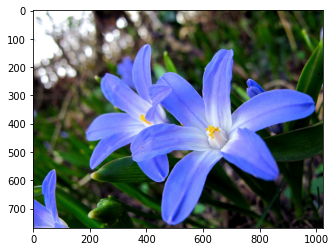

In [61]:
# load and show an image with Pillow
# Open the image form working directory
image = Image.open('flower.png')
plt.imshow(np.asarray(image))
f = image

## Real-time Image Smoothing via Iterative Least Squares Algorithm

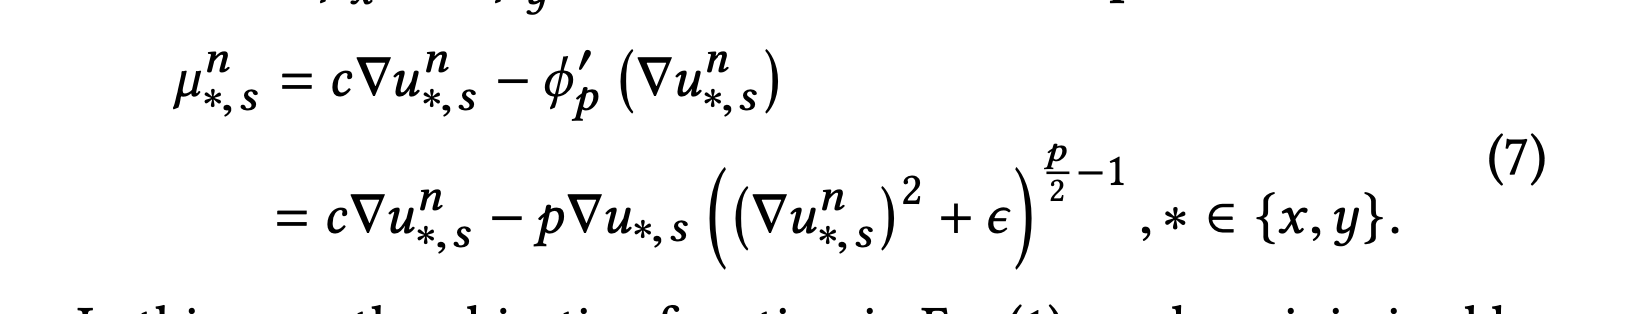

In [25]:
from IPython.display import Image
Image(filename='eq7.png') 



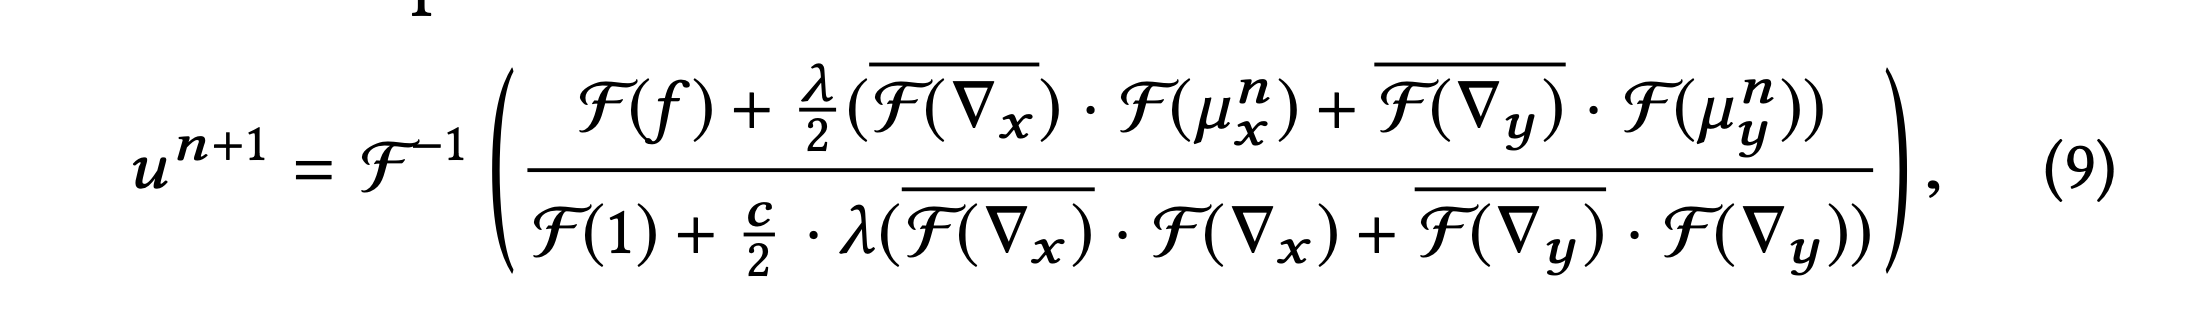

In [19]:
Image(filename='eq9.png') 


In [26]:
# point spread function (PSF) is impulse response, describes the response of an imaging system to a point source or point object.
# optical transfer function (OTF) is defined as the Fourier transform of the point spread function 
# ---------------------------------------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed Image')

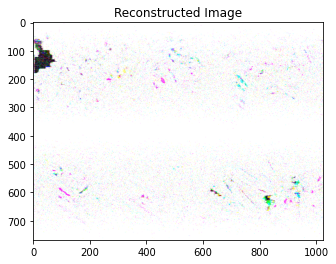

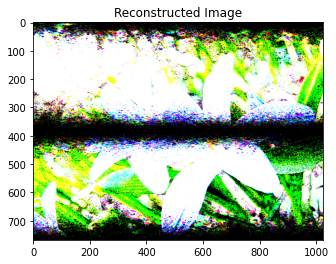

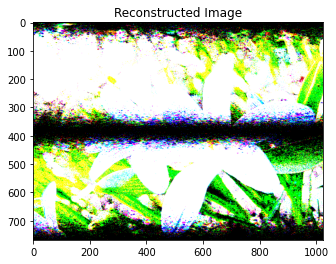

In [59]:
def psf2otf_Dx(outSize):
    psf = np.zeros(outSize)
    psf = psf.astype('float32')
    psf[0, 0] = -1
    psf[0, -1] = 1
    otf = fft2(psf)
    return otf


def psf2otf_Dy(outSize):
    psf = np.zeros(outSize)
    psf = psf.astype('float32')
    psf[0, 0] = -1
    psf[-1, 0] = 1
    otf = fft2(psf)
    return otf


lam = 1
k = 4
p = 0.8
eps = 0.0001
gamma = 0.5 * p - 1
c =  p * eps**gamma
image = Image.open('flower.png')
F = np.asarray(image)
N, M, D = f.shape # (768, 1024, 3)
sizeI2D = [N, M]


# pre-compute
otfFx = psf2otf_Dx(sizeI2D)
otfFy = psf2otf_Dy(sizeI2D)

Denormin = abs(otfFx)**2 + abs(otfFy )**2
Denormin = Denormin[:,:, np.newaxis]
Denormin = np.repeat(Denormin, D, axis=2)
denominator = 1 + 0.5 * c * lam * Denormin
U = F
normin1 = fft2(U)

for i in range(4):
    ## Step 1:  eq 7 - Intermediate variables \mu update, in x-axis and y-axis direction
    
    # Gradients delta u on x axis and delta u on y axis
    
    # image gradient in x direction
    u_extra_col = (U[:,0,:] - U[:,-1,:])[:,np.newaxis,:]
    u_extra_row = (U[0,:,:] - U[-1,:,:])[np.newaxis,:,:]
    
    u_h = np.hstack((np.diff(U,1,1), u_extra_col))
    u_v = np.vstack((np.diff(U,1,0), u_extra_row))

    mu_h = c * u_h - p * u_h * (u_h * u_h + eps)**gamma # (768, 1024, 3)
    mu_v = c * u_v - p * u_v * (u_v * u_v + eps)**gamma # (768, 1024, 3)

    ## ---------------------------------------------- ##
    ## Step 2: eq 9 - Update the smoothed image U
    
    # The diff causes loss in one columns
    extra_col = (mu_h[:,-1,:] - mu_h[:, 0,:])[:,np.newaxis,:]
    extra_row = (mu_v[-1,:,:] - mu_v[0,:,:])[np.newaxis,:,:]    

    # we calculate the diff - the inverse first order derivative of μxn along x-axis & μyn along y-axis 
    normin2_h = np.hstack((extra_col, - np.diff(mu_h,1,1)))
    normin2_v = np.vstack((extra_row, - np.diff(mu_v,1,0)))
    
    numerator = (normin1 + 0.5 * lam * (fft2(normin2_h + normin2_v)))

    FU = numerator / denominator   
#     U = ifft2(FU).real
    U = np.abs(ifft2(FU))
    # reverse the 2D fourier transform
#     freq_filt_img = ifft2(ifftshift(FU))
#     freq_filt_img = np.abs(freq_filt_img)
#     U = freq_filt_img.astype(np.uint8)

    normin1 = FU 

smoothed = U
diff = F - smoothed
image_new = F + 3 * diff

plt.figure()
plt.imshow(smoothed)
plt.title('Reconstructed Image')

plt.figure()
plt.imshow(diff)
plt.title('Reconstructed Image')

plt.figure()
plt.imshow(image_new)
plt.title('Reconstructed Image')




## Apply Weighted average based method (gaussian_filter)

In [24]:
# import cv2 as cv
# from matplotlib import pyplot as plt

# img = cv.imread('flower.png')
# kernel = np.ones((5,5),np.float32)/25
# dst = cv.filter2D(img,-1,kernel)
# plt.imshow(img),plt.title('Averaging')
# plt.show()
